In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import exp

In [2]:
from guess_query import GuessQueryProblem

# Setup

In [3]:
original = GuessQueryProblem(discount_factor=0.99,
                             guess_correct_reward = 1,
                             guess_wrong_cost = 0,
                             query_cost = 0,
                             N = 1001,
                             convergence_tol = 10e-5)


In [4]:
original.solve()

# Value function

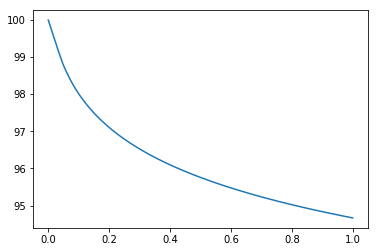

In [6]:
plt.plot(original.discretization, original.expected_value_function)

## Exponential fit (better than quadratic)

[-4.2287778]


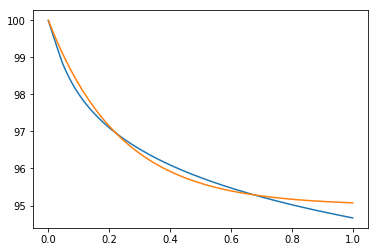

In [8]:
def f(x, b):
    foo = 95
    return (100 - foo) * np.exp(b * x) + foo

popt, pcov = curve_fit(f, original.discretization, original.expected_value_function)
print(popt)

plt.plot(original.discretization, original.expected_value_function)
plt.plot(original.discretization, f(original.discretization, *popt))

# Optimal action (1 is guess)

## At m = 0.1

In [71]:
problem = original
m_index = 100
relevant = np.argmax(problem.action_function, axis = 0)

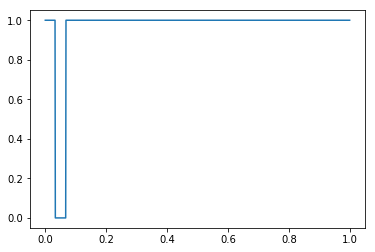

In [72]:
plt.plot(original.discretization, relevant[m_index])
# "Sweet spot" for querying. 

### Query at a distance x or more from the endpoints of the unknown interval.


In [73]:
original.discretization[np.argmax(relevant[m_index] == 0)]

0.033

## start-querying point x as a function of m

In [74]:
# First time it is better to query
break_evens = np.argmax(relevant == 0, axis=1)

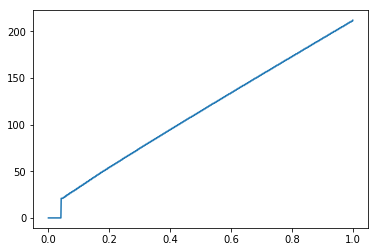

In [75]:
plt.plot(original.discretization, break_evens)

In [76]:
# Consistent with before.
original.discretization[break_evens[100]]

0.033

### For small m, you should always guess--payoff comes too far in the future. Smallest m at which querying is sometimes optimal:

In [78]:
always_guess_index = np.argmax(break_evens > 0)
always_guess_point = original.discretization[always_guess_index]
# Agrees with my back-of-the-envelope calculation perfectly... :D :D :D 
print(always_guess_point)

0.042


Pencil and paper analysis for this smallest m gives

In [79]:
4 * (1 - original.discount_factor) / original.discount_factor

0.04040404040404044

which agrees fairly closely (I think to within discretization error).

## Line fit of start-querying point vs. m

In [81]:
# linear region
nonzero_break_evens = break_evens[always_guess_index:]

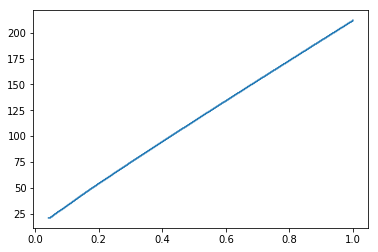

In [82]:
plt.plot(original.discretization[always_guess_index:], nonzero_break_evens)

[198.55693561  22.68267727]


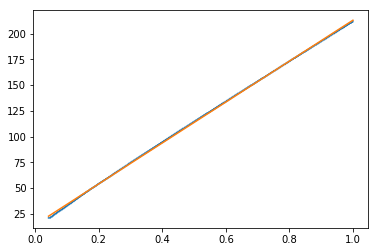

In [84]:
def f(x, a, b):
    return a * (x - always_guess_point) + b

popt, pcov = curve_fit(f, original.discretization[always_guess_index:], nonzero_break_evens)
print(popt)

plt.plot(original.discretization[always_guess_index:], nonzero_break_evens)
plt.plot(original.discretization[always_guess_index:], f(original.discretization[always_guess_index:], *popt))
# plt.plot(original.discretization, f(original.discretization, 100, -0.1))

Looks almost perfectly linear. 

## Size of region where querying is optimal (which is centered on midpoint of unknown region) vs. m

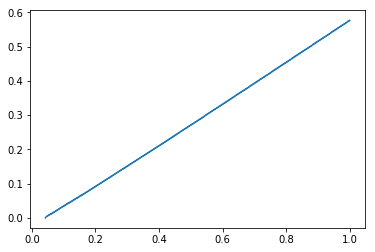

In [95]:
query_region_size = 2 * (original.discretization[always_guess_index:]/2 - \
                         original.discretization[nonzero_break_evens])
plt.plot(original.discretization[always_guess_index:], query_region_size)

This gives us a functional form for the policy: it is a threshold policy where you never query up to a critical size m_0 (= 42 here). At that critical size, you query only at the center point (m = 21). After that, for each additional unit of size, you get 0.6 more points you're willing to query.
It seems like we should be able to use this functional form to derive
an exact solution for the optimal policy and value function.